In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')
train = pd.read_csv("/content/drive/MyDrive/data/novel/train.csv")
test = pd.read_csv("/content/drive/MyDrive/data/novel/test_x.csv")

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/data/novel/sample_submission.csv")
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


In [ ]:
# 전처리
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


In [ ]:

train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [ ]:
#  train 데이터와 test 데이터 배열로 전환
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)


print(X_train)
print(X_test)
print(Y_train)

(54879,)
(19617,)
(54879,)
['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere wellwisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner h

In [ ]:

from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
               
tokenizer.fit_on_texts(X_train) 
sequences_train = tokenizer.texts_to_sequences(X_train)    
sequences_test = tokenizer.texts_to_sequences(X_test)      

print(len(sequences_train), len(sequences_test))


54879 19617


In [ ]:


word_index = tokenizer.word_index
max_length = 150   
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [ ]:

train_y = np_utils.to_categorical(Y_train) 
print(train_y)
print(train_y.shape)


[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


In [ ]:

vocab_size = 2000 
embedding_dim = 200  
max_length = 150   
padding_type='post'


In [ ]:
# 양방향 LSTM 레이어를 사용한 모델 (mode2) 정의
mode2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(5, activation='softmax')    
    ])
    
mode2.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
mode2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 200)          400000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 150, 128)          135680    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 150, 128)          98816     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 733,957
Trainable params: 733,957
Non-trainable params: 0
_________________________________________________________________


In [ ]:

past = mode2.fit(train_x, train_y, epochs=30, batch_size=100, validation_split= 0.2) 
 

Epoch 1/30
440/440 [==============================] - 678s 2s/step - loss: 1.2910 - accuracy: 0.4532 - val_loss: 0.9125 - val_accuracy: 0.6464
Epoch 2/30
440/440 [==============================] - 666s 2s/step - loss: 0.8556 - accuracy: 0.6742 - val_loss: 0.8917 - val_accuracy: 0.6585
Epoch 3/30
440/440 [==============================] - 665s 2s/step - loss: 0.7817 - accuracy: 0.6993 - val_loss: 0.8729 - val_accuracy: 0.6687
Epoch 4/30
440/440 [==============================] - 667s 2s/step - loss: 0.7420 - accuracy: 0.7160 - val_loss: 0.9016 - val_accuracy: 0.6591
Epoch 5/30
440/440 [==============================] - 683s 2s/step - loss: 0.7165 - accuracy: 0.7269 - val_loss: 0.8983 - val_accuracy: 0.6621
Epoch 6/30
440/440 [==============================] - 679s 2s/step - loss: 0.6755 - accuracy: 0.7433 - val_loss: 0.9203 - val_accuracy: 0.6591
Epoch 7/30
440/440 [==============================] - 676s 2s/step - loss: 0.6553 - accuracy: 0.7505 - val_loss: 0.9687 - val_accuracy: 0.6463

<function matplotlib.pyplot.show>

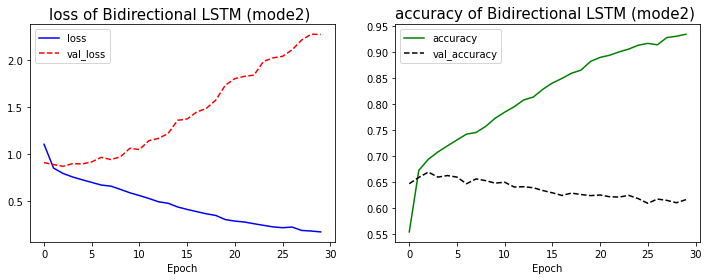

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (mode2) ', fontsize= 15)
plt.plot( past.history['loss'], 'b-', label='loss')
plt.plot( past.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (mode2) ', fontsize= 15)
plt.plot(past.history['accuracy'], 'g-', label='accuracy')
plt.plot(past.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:

vocab_size = 2000 
embedding_dim = 200  
max_length = 150    
padding_type='post'

In [ ]:
# LSTM 레이어를 사용한 모델 (mode1) 정의
mode1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
mode1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
mode1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 200)          400000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 150, 64)           67840     
_________________________________________________________________
lstm_13 (LSTM)               (None, 150, 64)           33024     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [ ]:

past = mode1.fit(train_x, train_y, epochs=5, batch_size=100, validation_split= 0.2) 


Epoch 1/5
440/440 [==============================] - 296s 673ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5716 - val_accuracy: 0.2680
Epoch 2/5
440/440 [==============================] - 296s 673ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5717 - val_accuracy: 0.2680
Epoch 3/5
440/440 [==============================] - 296s 673ms/step - loss: 1.5704 - accuracy: 0.2759 - val_loss: 1.5713 - val_accuracy: 0.2680
Epoch 4/5
440/440 [==============================] - 297s 674ms/step - loss: 1.5283 - accuracy: 0.2988 - val_loss: 1.4353 - val_accuracy: 0.3510
Epoch 5/5
440/440 [==============================] - 296s 673ms/step - loss: 1.4021 - accuracy: 0.3636 - val_loss: 1.3772 - val_accuracy: 0.3754


<function matplotlib.pyplot.show>

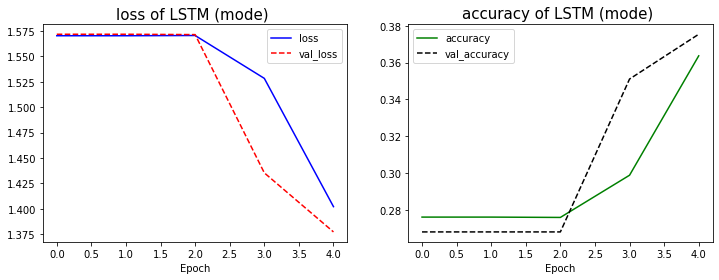

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (mode) ', fontsize= 15)
plt.plot(past.history['loss'], 'b-', label='loss')
plt.plot(past.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (mode) ', fontsize= 15)
plt.plot(past.history['accuracy'], 'g-', label='accuracy')
plt.plot(past.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
n_fold = 5  
test_y = np.zeros((test_x.shape[0], 5))
test_y += mode2.predict(test_x) / n_fold 

In [ ]:
test_y

array([[1.38553604e-02, 1.39896303e-01, 3.44273448e-02, 9.55111161e-03,
        2.26986199e-03],
       [4.06250432e-02, 1.39323622e-01, 3.68474936e-03, 4.73351218e-03,
        1.16330832e-02],
       [1.38667554e-01, 5.49345091e-03, 3.79316439e-03, 2.03215564e-03,
        5.00136726e-02],
       ...,
       [3.35457246e-03, 1.95700556e-01, 2.96910846e-04, 4.61004849e-04,
        1.86966223e-04],
       [2.68319901e-03, 1.92729086e-01, 9.33578995e-04, 3.00188246e-03,
        6.52257469e-04],
       [4.01718430e-02, 7.35491514e-03, 1.35807544e-01, 8.51380546e-03,
        8.15187581e-03]])

In [ ]:
sample_submission[['0','1','2','3','4']] = test_y
sample_submission

,index,0,1,2,3,4
0,0,0.013855,0.139896,0.034427,0.009551,0.002270
1,1,0.040625,0.139324,0.003685,0.004734,0.011633
2,2,0.138668,0.005493,0.003793,0.002032,0.050014
3,3,0.000989,0.001710,0.185331,0.001043,0.010927
4,4,0.061441,0.085305,0.003696,0.040613,0.008945
...,...,...,...,...,...,...
19612,19612,0.001626,0.197493,0.000256,0.000426,0.000198
19613,19613,0.004280,0.001161,0.019167,0.000435,0.174957
19614,19614,0.003355,0.195701,0.000297,0.000461,0.000187
19615,19615,0.002683,0.192729,0.000934,0.003002,0.000652
